## Gaussian Processes (GP): ##
GP are a generic supervised learning method designed to solve regression and probabilistic classification problems.

#### The advantages of Gaussian processes are:####
    1) The prediction interpolates the observations (at least for regular kernels).
    2) The prediction is probabilistic (Gaussian) so that one can compute empirical confidence intervals and decide   based on those if one should refit (online fitting, adaptive fitting) the prediction in some region of interest.
    
    Versatile: different kernels can be specified. Common kernels are provided, but it is also possible to specify custom kernels.

#### The disadvantages of Gaussian processes include ####

    1) They are not sparse, i.e., they use the whole samples/features information to perform the prediction.
    2) They lose efficiency in high dimensional spaces – namely when the number of features exceeds a few dozens.

### Gaussian Process Regression (GPR) ###

The GaussianProcessRegressor implements Gaussian processes (GP) for regression purposes. For this, the prior of the GP needs to be specified. The prior mean is assumed to be constant and zero (for normalize_y=False) or the training data’s mean (for normalize_y=True). The prior’s covariance is specified by passing a kernel object. The hyperparameters of the kernel are optimized during fitting of GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) based on the passed optimizer. As the LML may have multiple local optima, the optimizer can be started repeatedly by specifying n_restarts_optimizer. The first run is always conducted starting from the initial hyperparameter values of the kernel; subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values. If the initial hyperparameters should be kept fixed, None can be passed as optimizer.

The noise level in the targets can be specified by passing it via the parameter alpha, either globally as a scalar or per datapoint. Note that a moderate noise level can also be helpful for dealing with numeric issues during fitting as it is effectively implemented as Tikhonov regularization, i.e., by adding it to the diagonal of the kernel matrix. An alternative to specifying the noise level explicitly is to include a WhiteKernel component into the kernel, which can estimate the global noise level from the data (see example below).

The implementation is based on Algorithm 2.1 of [RW2006]. In addition to the API of standard scikit-learn estimators, 

#### GaussianProcessRegressor: ####

    1) Allows prediction without prior fitting (based on the GP prior)
    2) provides an additional method sample_y(X), which evaluates samples drawn from the GPR (prior or posterior) at given inputs

exposes a method log_marginal_likelihood(theta), which can be used externally for other ways of selecting hyperparameters, e.g., via Markov chain Monte Carlo.

## GPR with noise-level estimation ##

This example illustrates that GPR with a sum-kernel including a WhiteKernel can estimate the noise level of data. An illustration of the log-marginal-likelihood (LML) landscape shows that there exist two local maxima of LML.

In [4]:
import numpy as np


def target_generator(X, add_noise=False):
    target = 0.5 + np.sin(3 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.3, size=target.shape)
    return target.squeeze()

X = np.linspace(0, 5, num=30).reshape(-1, 1)
#print(X)
y = target_generator(X, add_noise=False)
#print(y)

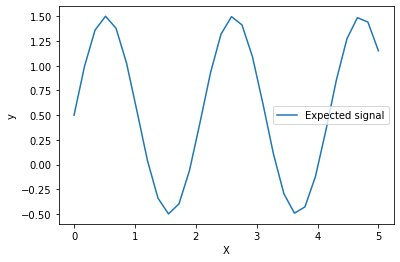

In [5]:
import matplotlib.pyplot as plt

plt.plot(X, y, label="Expected signal")
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

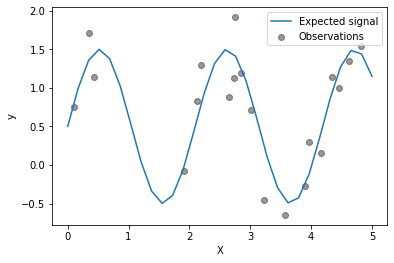

In [6]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 5, size=20).reshape(-1, 1)
y_train = target_generator(X_train, add_noise=True)

plt.plot(X, y, label="Expected signal")
plt.scatter(
    x=X_train[:, 0],
    y=y_train,
    color="black",
    alpha=0.4,
    label="Observations",
)
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

#### Optimisation of kernel hyperparameters in GPR ####

Now, we will create a GaussianProcessRegressor using an additive kernel adding a RBF and WhiteKernel kernels. The WhiteKernel is a kernel that will able to estimate the amount of noise present in the data while the RBF will serve at fitting the non-linearity between the data and the target.

However, we will show that the hyperparameter space contains several local minima. It will highlights the importance of initial hyperparameter values.

We will create a model using a kernel with a high noise level and a large length scale, which will explain all variations in the data by noise.

/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


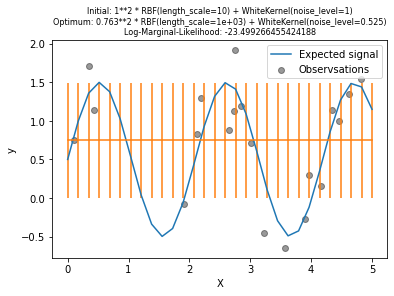

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observsations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
    f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}",
    fontsize=8,
)


We see that the optimum kernel found still have a high noise level and an even larger length scale. Furthermore, we observe that the model does not provide faithful predictions.

Now, we will initialize the RBF with a larger length_scale and the WhiteKernel with a smaller noise level lower bound.



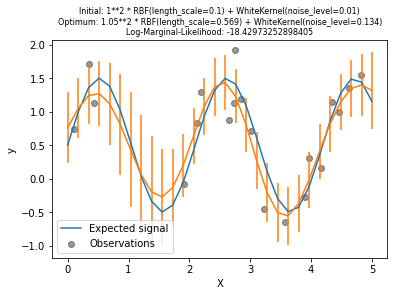

In [8]:
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
    f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}",
    fontsize=8,
)


## Gaussian Process Classification ##
### Probabilistic predictions with GPC ###

Log Marginal Likelihood (initial): -17.598
Log Marginal Likelihood (optimized): -3.875
Accuracy: 1.000 (initial) 1.000 (optimized)
Log-loss: 0.214 (initial) 0.319 (optimized)


/var/folders/pw/423gbs8x6pgcnpjz__9p39640000gq/T/ipykernel_65055/1182849161.py:94: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Theta0, Theta1, LML)


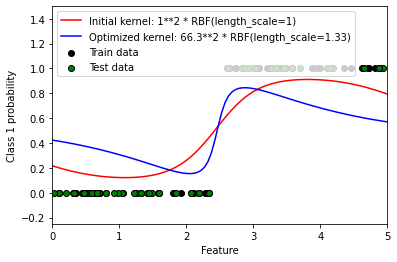

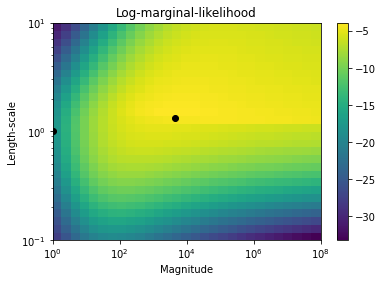

In [9]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


# Generate data
train_size = 50
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 100)[:, np.newaxis]
y = np.array(X[:, 0] > 2.5, dtype=int)

# Specify Gaussian Processes with fixed and optimized hyperparameters
gp_fix = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0), optimizer=None)
gp_fix.fit(X[:train_size], y[:train_size])

gp_opt = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
gp_opt.fit(X[:train_size], y[:train_size])

print(
    "Log Marginal Likelihood (initial): %.3f"
    % gp_fix.log_marginal_likelihood(gp_fix.kernel_.theta)
)
print(
    "Log Marginal Likelihood (optimized): %.3f"
    % gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta)
)

print(
    "Accuracy: %.3f (initial) %.3f (optimized)"
    % (
        accuracy_score(y[:train_size], gp_fix.predict(X[:train_size])),
        accuracy_score(y[:train_size], gp_opt.predict(X[:train_size])),
    )
)
print(
    "Log-loss: %.3f (initial) %.3f (optimized)"
    % (
        log_loss(y[:train_size], gp_fix.predict_proba(X[:train_size])[:, 1]),
        log_loss(y[:train_size], gp_opt.predict_proba(X[:train_size])[:, 1]),
    )
)


# Plot posteriors
plt.figure()
plt.scatter(
    X[:train_size, 0], y[:train_size], c="k", label="Train data", edgecolors=(0, 0, 0)
)
plt.scatter(
    X[train_size:, 0], y[train_size:], c="g", label="Test data", edgecolors=(0, 0, 0)
)
X_ = np.linspace(0, 5, 100)
plt.plot(
    X_,
    gp_fix.predict_proba(X_[:, np.newaxis])[:, 1],
    "r",
    label="Initial kernel: %s" % gp_fix.kernel_,
)
plt.plot(
    X_,
    gp_opt.predict_proba(X_[:, np.newaxis])[:, 1],
    "b",
    label="Optimized kernel: %s" % gp_opt.kernel_,
)
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")

# Plot LML landscape
plt.figure()
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [
    [
        gp_opt.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])
    ]
    for j in range(Theta0.shape[1])
]
LML = np.array(LML).T
plt.plot(
    np.exp(gp_fix.kernel_.theta)[0], np.exp(gp_fix.kernel_.theta)[1], "ko", zorder=10
)
plt.plot(
    np.exp(gp_opt.kernel_.theta)[0], np.exp(gp_opt.kernel_.theta)[1], "ko", zorder=10
)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")

plt.show()